# Rough Models Calibration Demo

*This notebook shows how to calibrate two rough volatility models:*

- **rBergomi** — parameters: *(H, η, ρ, ξ₀)*.
- **Rough Heston** — parameters: *(v₀, κ, θ, η, ρ, H)*.

**We’ll do:**
1. Load helpers and define a robust implied-vol wrapper (handles dividend yield `q`).
2. Build a sample smile (you can replace with your market data).
3. Calibrate **rBergomi** in IV space (vega-weighted).
4. Calibrate **Rough Heston** in price space with optional ATM/skew penalties.
5. Visualize model vs market prices and IVs + residuals.
6. (Optional) Coarse→Refine two-stage calibration for speed & robustness.


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import sys
import os


# Add the repo root (one level up from notebooks) to Python path
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_root)

# Your library
from src.calibration import calibrate_rbergomi, calibrate_rough_heston
from src.rough import rbergomi_paths,rough_heston_paths
from src.black_scholes import black_scholes_price
from src.volatility import implied_volatility  # your q-less IV solver

# --- IV wrapper that handles q by mapping to a no-dividend equivalent ---
def implied_vol_q(price, S, K, T, r, q, option_type="call"):
    """
    Map (S, r, q) to a no-dividend-equivalent (Seff, reff) and call your IV solver:
        Seff = S * exp(-q T),   reff = r - q
    """
    Seff = S * math.exp(-q * T)
    reff = r - q
    return implied_volatility(price, Seff, K, T, reff, option_type=option_type)

# --- A tiny helper to compute model IVs from prices for plotting ---
def prices_to_ivs(S, r, q, T, strikes, prices, option_type="call"):
    ivs = []
    for K, p in zip(strikes, prices):
        try:
            ivs.append(implied_vol_q(p, S, K, T, r, q, option_type))
        except Exception:
            ivs.append(np.nan)
    return np.array(ivs, dtype=float)


## Sample Smile (You can replace with market data)

*Replace the arrays below with your own strikes & mid prices per maturity.*
*You can also add more maturities by appending to `smiles` a tuple `(S0, r, q, T, strikes, mids, "call" or "put")`.*


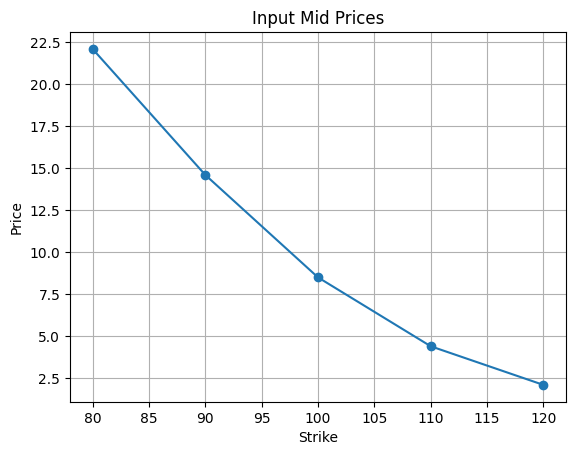

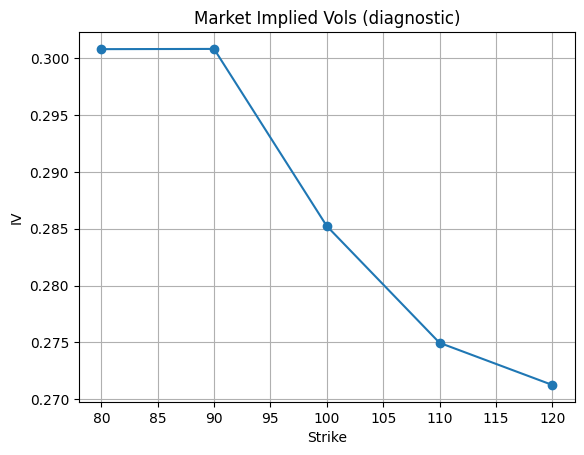

In [2]:
# Basic market setup
S0 = 100.0
r, q = 0.02, 0.00   # set your dividend yield here
T  = 0.50

# A flat-ish example smile (replace with your own)
strikes = np.array([80, 90, 100, 110, 120], float)
mids    = np.array([22.10, 14.60,  8.50,  4.40,  2.10], float)

cp = "call"
smiles = [(S0, r, q, T, strikes, mids, cp)]

# Plot the raw mid prices
plt.figure()
plt.plot(strikes, mids, marker="o")
plt.title("Input Mid Prices")
plt.xlabel("Strike")
plt.ylabel("Price")
plt.grid(True)
plt.show()

# Convert to market IVs (diagnostic)
mkt_iv = prices_to_ivs(S0, r, q, T, strikes, mids, option_type=cp)
plt.figure()
plt.plot(strikes, mkt_iv, marker="o")
plt.title("Market Implied Vols (diagnostic)")
plt.xlabel("Strike")
plt.ylabel("IV")
plt.grid(True)
plt.show()


## rBergomi Calibration (IV-space)

*Settings:*
- **Metric:** IV
- **Vega-weighted:** Yes
- **MC controls:** adjust `paths` / `N` as needed
- **Multistart:** a few random starts around `x0` improves robustness

*Params estimated:* `(H, eta, rho, xi0)`


In [3]:
rb_cfg = dict(N=192, paths=12000, fgn_method="davies-harte")
rb_x0  = (0.12, 1.4, -0.6, 0.04)   # (H, eta, rho, xi0)

best_rb, raw_rb = calibrate_rbergomi(
    smiles,
    metric="iv",
    vega_weight=True,
    x0=rb_x0,
    mc=rb_cfg,
    multistart=3,
    options={"maxiter": 150}
)

print("rBergomi best:", best_rb)


[rBergomi #1 start #1] iter=0
[rBergomi #1] iter=1  f=0.000990  Δf=nan  |Δx|=nan  9.88s
[rBergomi #1] iter=2  f=0.000918  Δf=-7.23e-05  |Δx|=1.85e-03  2.40s
[rBergomi #1] iter=3  f=0.000898  Δf=-2.00e-05  |Δx|=1.65e-03  2.43s
[rBergomi #1] iter=4  f=0.000898  Δf=-5.86e-08  |Δx|=6.77e-05  2.29s
[rBergomi #1] iter=5  f=0.000898  Δf=-1.32e-07  |Δx|=2.06e-04  2.28s
[rBergomi #1] iter=6  f=0.000897  Δf=-3.47e-07  |Δx|=6.60e-04  2.32s
[rBergomi #1] iter=7  f=0.000897  Δf=-8.91e-07  |Δx|=1.75e-03  2.33s
[rBergomi #1] iter=8  f=0.000894  Δf=-3.07e-06  |Δx|=7.63e-03  2.30s
[rBergomi #1] iter=9  f=0.000889  Δf=-4.90e-06  |Δx|=1.01e-02  2.30s
[rBergomi #1] iter=10  f=0.000576  Δf=-3.13e-04  |Δx|=4.44e-01  4.70s
[rBergomi #1] iter=11  f=0.000576  Δf=-3.05e-07  |Δx|=9.03e-05  2.30s
[rBergomi #1] iter=12  f=0.000575  Δf=-6.20e-07  |Δx|=4.29e-04  2.31s
[rBergomi #1] iter=13  f=0.000575  Δf=-3.51e-07  |Δx|=5.92e-04  4.60s
[rBergomi #1] iter=14  f=0.000573  Δf=-1.73e-06  |Δx|=3.03e-03  2.28s
[rBergomi 

## rBergomi: Model vs Market (Prices & IVs)

*We simulate once per maturity using the calibrated parameters, then price the whole smile.*


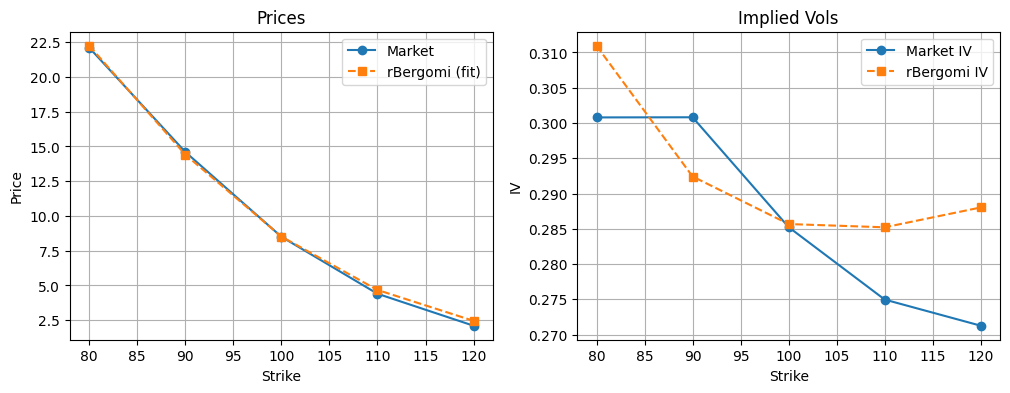

rBergomi IV RMSE: 0.01058568104481695


In [4]:
# Simulate once at the fitted params for the maturity
(H, eta, rho, xi0) = (best_rb["H"], best_rb["eta"], best_rb["rho"], best_rb["xi0"])
t, S_paths, V_paths = rbergomi_paths(
    S0=S0, T=T, N=rb_cfg["N"], n_paths=rb_cfg["paths"],
    H=H, eta=eta, rho=rho, xi0=xi0, r=r, q=q, seed=12345,
    fgn_method=rb_cfg["fgn_method"]
)
ST = S_paths[:, -1]
DF = math.exp(-r * T)
model_prices_rb = np.array([np.mean(DF*np.maximum(ST-K, 0.0)) for K in strikes])
model_ivs_rb    = prices_to_ivs(S0, r, q, T, strikes, model_prices_rb, option_type=cp)

# Plots
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(strikes, mids, "o-", label="Market")
ax[0].plot(strikes, model_prices_rb, "s--", label="rBergomi (fit)")
ax[0].set_title("Prices")
ax[0].set_xlabel("Strike"); ax[0].set_ylabel("Price"); ax[0].grid(True); ax[0].legend()

ax[1].plot(strikes, mkt_iv, "o-", label="Market IV")
ax[1].plot(strikes, model_ivs_rb, "s--", label="rBergomi IV")
ax[1].set_title("Implied Vols")
ax[1].set_xlabel("Strike"); ax[1].set_ylabel("IV"); ax[1].grid(True); ax[1].legend()

plt.show()

# Residuals (IV RMSE diagnostic)
iv_resid_rb = model_ivs_rb - mkt_iv
iv_rmse_rb  = float(np.sqrt(np.nanmean(iv_resid_rb**2)))
print("rBergomi IV RMSE:", iv_rmse_rb)


## Rough Heston Calibration (Price-space)
*Why price-space?* It avoids calling IV inversion inside the objective and is often more stable.

**Optional:** Add a soft **ATM** and/or **skew** penalty in your `calibration_rough.py` objective if your market smile is near-flat.  
(*See the comments in our earlier discussion for the exact snippet to add in `_rough_heston_objective`.*)


In [5]:
# MC controls; bump paths for a smoother objective, increase batch_size to heat up BLAS
rh_cfg = dict(N=192, paths=10000, batch_size=2048)

# Initial guess and bounds that discourage very heavy skew (tune to your market)
rh_x0 = (0.06, 1.2, 0.06, 0.6, -0.2, 0.15)  # (v0,kappa,theta,eta,rho,H)
rh_bounds = (
    (0.01, 0.20),   # v0
    (0.4,  3.0),    # kappa
    (0.01, 0.20),   # theta
    (0.1,  1.0),    # eta
    (-0.5, 0.1),    # rho
    (0.08, 0.30),   # H
)

best_rh, raw_rh = calibrate_rough_heston(
    smiles,
    metric="price",          # price-space objective
    vega_weight=False,       # (price mode); if you implemented vega-weighting in price space, set True and ensure objective multiplies weights
    x0=rh_x0,
    bounds=rh_bounds,
    mc=rh_cfg,
    multistart=3,
    options={"maxiter": 150}
)

print("Rough Heston best:", best_rh)


[RoughHeston #1 start #1] iter=0
[RoughHeston #1] iter=1  f=0.786899  Δf=nan  |Δx|=nan  57.89s
[RoughHeston #1] iter=2  f=0.248301  Δf=-5.39e-01  |Δx|=3.07e-02  25.71s
[RoughHeston #1] iter=3  f=0.224858  Δf=-2.34e-02  |Δx|=1.91e-02  27.32s
[RoughHeston #1] iter=4  f=0.214222  Δf=-1.06e-02  |Δx|=9.33e-03  25.23s
[RoughHeston #1] iter=5  f=0.187932  Δf=-2.63e-02  |Δx|=3.64e-02  109.93s
[RoughHeston #1] iter=6  f=0.178514  Δf=-9.42e-03  |Δx|=3.92e-02  42.83s
[RoughHeston #1] iter=7  f=0.159689  Δf=-1.88e-02  |Δx|=6.45e-03  21.63s
[RoughHeston #1] iter=8  f=0.130653  Δf=-2.90e-02  |Δx|=1.99e-02  47.59s
[RoughHeston #1] iter=9  f=0.120524  Δf=-1.01e-02  |Δx|=1.23e-02  26.74s
[RoughHeston #1] iter=10  f=0.057170  Δf=-6.34e-02  |Δx|=1.16e-01  26.82s
[RoughHeston #1] iter=11  f=0.043573  Δf=-1.36e-02  |Δx|=2.78e-02  58.59s
[RoughHeston #1] iter=12  f=0.038388  Δf=-5.19e-03  |Δx|=4.75e-02  57.74s
[RoughHeston #1] iter=13  f=0.032288  Δf=-6.10e-03  |Δx|=2.45e-02  19.52s
[RoughHeston #1] iter=14

## Rough Heston: Model vs Market (Prices & IVs)

*We re-simulate at the fitted params and compare against the input smile.*


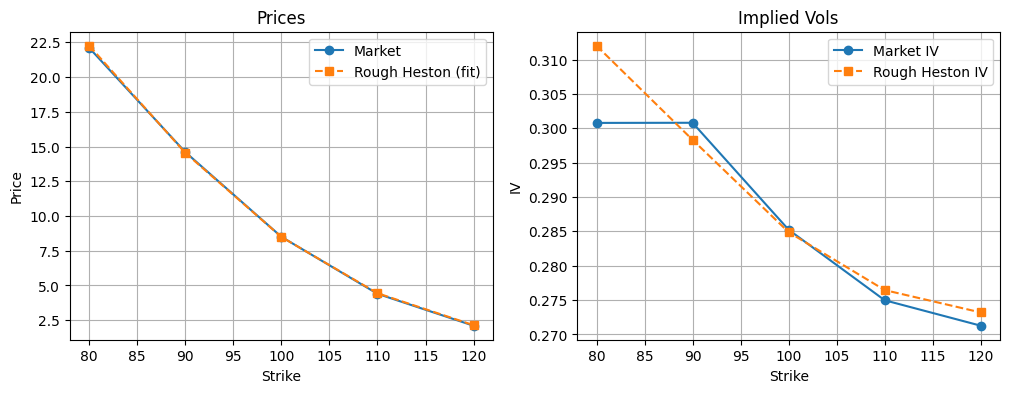

Rough Heston: IV RMSE: 0.005264091016359591  | Price RMSE: 0.07894485480739322


In [6]:
p = best_rh
t, S_rh, V_rh = rough_heston_paths(
    S0=S0, v0=p["v0"], T=T, N=rh_cfg["N"], n_paths=rh_cfg["paths"],
    H=p["H"], kappa=p["kappa"], theta=p["theta"], eta=p["eta"], rho=p["rho"],
    r=r, q=q, seed=22222, batch_size=rh_cfg["batch_size"]
)
ST_rh = S_rh[:, -1]
DF = math.exp(-r * T)
model_prices_rh = np.array([np.mean(DF*np.maximum(ST_rh-K, 0.0)) for K in strikes])
model_ivs_rh    = prices_to_ivs(S0, r, q, T, strikes, model_prices_rh, option_type=cp)

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(strikes, mids, "o-", label="Market")
ax[0].plot(strikes, model_prices_rh, "s--", label="Rough Heston (fit)")
ax[0].set_title("Prices")
ax[0].set_xlabel("Strike"); ax[0].set_ylabel("Price"); ax[0].grid(True); ax[0].legend()

ax[1].plot(strikes, mkt_iv, "o-", label="Market IV")
ax[1].plot(strikes, model_ivs_rh, "s--", label="Rough Heston IV")
ax[1].set_title("Implied Vols")
ax[1].set_xlabel("Strike"); ax[1].set_ylabel("IV"); ax[1].grid(True); ax[1].legend()

plt.show()

# Diagnostics
iv_resid_rh = model_ivs_rh - mkt_iv
iv_rmse_rh  = float(np.sqrt(np.nanmean(iv_resid_rh**2)))
px_rmse_rh  = float(np.sqrt(np.mean((model_prices_rh - mids)**2)))
print("Rough Heston: IV RMSE:", iv_rmse_rh, " | Price RMSE:", px_rmse_rh)


## Optional: Two-Stage Calibration (Coarse → Refine)

*This procedure gets you close cheaply, then tightens with a richer MC budget.*


In [7]:
# --- Coarse stage ---
best_coarse, _ = calibrate_rough_heston(
    smiles,
    metric="price",
    vega_weight=False,
    x0=rh_x0,
    bounds=rh_bounds,
    mc=dict(N=128, paths=4000, batch_size=2048),
    multistart=2,
    options={"maxiter": 80}
)
print("Coarse RH:", best_coarse)

# --- Refine stage ---
x0_ref = (best_coarse["v0"], best_coarse["kappa"], best_coarse["theta"],
          best_coarse["eta"], best_coarse["rho"], best_coarse["H"])

best_refined, _ = calibrate_rough_heston(
    smiles,
    metric="price",
    vega_weight=False,
    x0=x0_ref,
    bounds=rh_bounds,
    mc=dict(N=192, paths=16000, batch_size=4096),
    multistart=1,
    options={"maxiter": 150}
)
print("Refined RH:", best_refined)


[RoughHeston #1 start #1] iter=0
[RoughHeston #1] iter=1  f=0.238913  Δf=nan  |Δx|=nan  9.50s
[RoughHeston #1] iter=2  f=0.096395  Δf=-1.43e-01  |Δx|=3.74e-02  3.08s
[RoughHeston #1] iter=3  f=0.088334  Δf=-8.06e-03  |Δx|=8.32e-03  3.05s
[RoughHeston #1] iter=4  f=0.087816  Δf=-5.18e-04  |Δx|=3.64e-03  3.09s
[RoughHeston #1] iter=5  f=0.087565  Δf=-2.51e-04  |Δx|=4.65e-03  3.02s
[RoughHeston #1] iter=6  f=0.085915  Δf=-1.65e-03  |Δx|=4.14e-03  6.29s
[RoughHeston #1] iter=7  f=0.084761  Δf=-1.15e-03  |Δx|=8.01e-03  3.09s
[RoughHeston #1] iter=8  f=0.078540  Δf=-6.22e-03  |Δx|=9.41e-02  3.04s
[RoughHeston #1] iter=9  f=0.077610  Δf=-9.31e-04  |Δx|=1.55e-02  3.04s
[RoughHeston #1] iter=10  f=0.077343  Δf=-2.66e-04  |Δx|=1.63e-02  9.17s
[RoughHeston #1] iter=11  f=0.076971  Δf=-3.73e-04  |Δx|=5.10e-03  3.05s
[RoughHeston #1] iter=12  f=0.076946  Δf=-2.42e-05  |Δx|=1.01e-03  12.19s
[RoughHeston #1] iter=13  f=0.076859  Δf=-8.75e-05  |Δx|=1.14e-03  3.06s
[RoughHeston #1] iter=14  f=0.076444 

## Robustness Tips

* Use **common random numbers** (seed per maturity) — already done in the calibration helpers.
* Add **antithetics** for both Gaussian streams (Z₁, Z₂) inside your path simulators to cut MC noise by ~2×.
* If the smile is **near-flat**, tighten bounds on ρ and η (weaker skew) and/or add a soft **ATM penalty** in the objective.
* For **multi-maturity** fits:
  - either calibrate each T separately first to seed a joint surface fit,
  - or parallelize per-maturity sims inside the objective.
* If IV inversion is fragile for extreme strikes, prefer **metric="price"**, and use vega-like weights in price space to emphasize ATM/near-ATM.


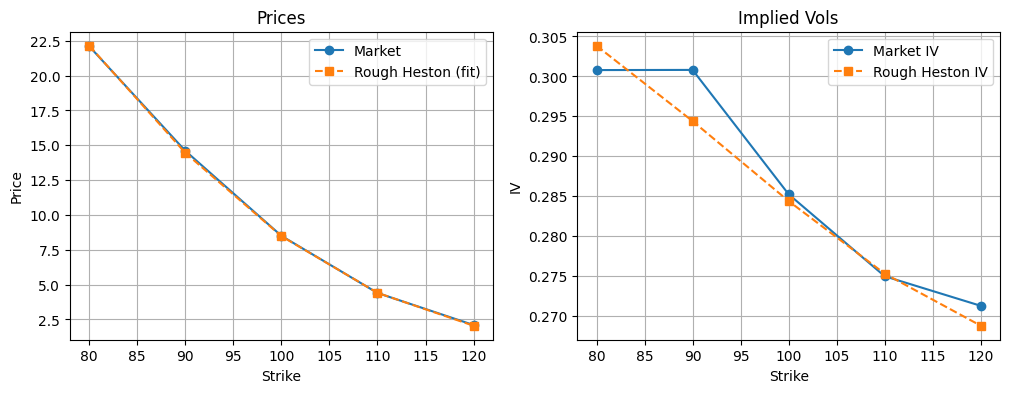

Rough Heston: IV RMSE: 0.003390037558422403  | Price RMSE: 0.07256458679004274


In [8]:
p = best_refined
t, S_rh, V_rh = rough_heston_paths(
    S0=S0, v0=p["v0"], T=T, N=rh_cfg["N"], n_paths=rh_cfg["paths"],
    H=p["H"], kappa=p["kappa"], theta=p["theta"], eta=p["eta"], rho=p["rho"],
    r=r, q=q, seed=22222, batch_size=rh_cfg["batch_size"]
)
ST_rh = S_rh[:, -1]
DF = math.exp(-r * T)
model_prices_rh = np.array([np.mean(DF*np.maximum(ST_rh-K, 0.0)) for K in strikes])
model_ivs_rh    = prices_to_ivs(S0, r, q, T, strikes, model_prices_rh, option_type=cp)

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(strikes, mids, "o-", label="Market")
ax[0].plot(strikes, model_prices_rh, "s--", label="Rough Heston (fit)")
ax[0].set_title("Prices")
ax[0].set_xlabel("Strike"); ax[0].set_ylabel("Price"); ax[0].grid(True); ax[0].legend()

ax[1].plot(strikes, mkt_iv, "o-", label="Market IV")
ax[1].plot(strikes, model_ivs_rh, "s--", label="Rough Heston IV")
ax[1].set_title("Implied Vols")
ax[1].set_xlabel("Strike"); ax[1].set_ylabel("IV"); ax[1].grid(True); ax[1].legend()

plt.show()

# Diagnostics
iv_resid_rh = model_ivs_rh - mkt_iv
iv_rmse_rh  = float(np.sqrt(np.nanmean(iv_resid_rh**2)))
px_rmse_rh  = float(np.sqrt(np.mean((model_prices_rh - mids)**2)))
print("Rough Heston: IV RMSE:", iv_rmse_rh, " | Price RMSE:", px_rmse_rh)
